In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
import statistics
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
import pickle
import seaborn as sns
from sklearn.metrics import classification_report,roc_auc_score,confusion_matrix,accuracy_score,f1_score,roc_curve
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.layers import Activation, Dense, Dropout, Embedding, LSTM
import re
from IPython.display import display
import os
import string
import time
import random
from keras import optimizers
import keras
import seaborn as sns
random.seed(10)
plt.style.use('classic')

2024-03-08 20:53:54.996460: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
blmbg_or = '#fb8b1e'
blmbg_blue = '#0068ff'
blmbg_red = '#ff433d'
blmbg_cyan = '#4af6c3'

In [3]:
dollar = yf.Ticker('EURUSD=X').history(period = '10y')['Open'].values

In [5]:
def regress(data1, data2):
    n = len(data1)
    x = data1.reshape(-1,1)
    y = data2
    model  = LinearRegression()
    model.fit(x,y)
    plt.figure()
    plt.plot(x[-n:], (model.coef_*x + model.intercept_)[-n:],color = 'b', lw = 0.4, label = f'Line of Best Fit, R2 = {round(model.score(x,y),5)}')
    plt.scatter(x[-n:],y[-n:])
    plt.legend()
    plt.xlabel('Data 1')
    plt.ylabel('Data 2')
    plt.title(f'Regression on Data 1 vs Data 2')
    plt.show()
    resid = []
    for i in range(len(x)):
        resid.append((y[i] - (model.coef_*x[i] + model.intercept_))[0])
    plt.figure(figsize = (12,6))
    plt.plot(resid)
    plt.xlabel('Data Points')
    plt.ylabel('Residual ($y - \hat{y}$)')
    plt.title('Residual of the Regression')
    plt.show()
    plt.figure(figsize = (12,6))
    plt.plot(np.abs(resid))
    plt.xlabel('Data Points')
    plt.ylabel('Absolute Residual ($|y - \hat{y}|$)')
    plt.title('Absolute Residual of the Regression')
    plt.show()
    plt.figure(figsize = (12,6))
    sns.kdeplot(resid, label = 'Vanilla Residual')
    plt.legend()
    plt.show()

In [6]:
o = yf.Ticker(ticker).history(period = '10y')['Open'].values
c = yf.Ticker(ticker).history(period = '10y')['Close'].values

NameError: name 'ticker' is not defined

In [4]:
regress(o,c)

NameError: name 'regress' is not defined

In [9]:
period = '10y'
ma1 = 3
ma2 = 5
ma3 = 10
def getData_BrentShift(shift):
    brent = yf.Ticker('BZ=F').history(period = period)
    brent_open = brent['Open']
    brent_close = brent['Close']

    wti_open = yf.Ticker('CL=F').history(period = period)['Open']
    wti_close = yf.Ticker('CL=F').history(period = period)['Close']

    brent = yf.Ticker('BZ=F').history(period = period)
    brent_vol = brent['Volume'].values

    dataset = pd.DataFrame([brent_open.values, brent_close.values, brent_vol, wti_open.values, wti_close.values, dollar], ['brent_open', 'brent_close', 'brent_volume', 'wti_open', 'wti_close', 'dollar'])
    dataset = dataset.transpose()
    dataset[f'{shift} Day Price'] = dataset['brent_close'].shift(-shift)

    rates = yf.Ticker('^TNX').history(period = period)
    rates_open = rates['Open'].values
    rates_close = rates['Close'].values
    rates_spread = (rates['Close'] - rates['Open'])
    dataset = dataset[-2509+shift-2:]
    natgas = yf.Ticker('NG=F').history(period = period)[-2509+shift-2:]
    dataset['natgas_open'] = natgas['Open'].values
    dataset['natgas_close'] = natgas['Close'].values

    dataset['natgas_open_MA50'] = dataset['natgas_open'].rolling(ma1).mean()
    dataset['natgas_close_MA50'] = dataset['natgas_close'].rolling(ma1).mean()

    rmb = yf.Ticker('CNY=X').history(period = period)['Open'].values
    rmb2 = [rmb[0]]
    for i in range(0,len(rmb)):
        rmb2.append(rmb[i])
    rmb = rmb2
    dataset['rmb'] = rmb[-2509+shift-2:]
    dataset['rmb_MA3'] = dataset['rmb'].rolling(ma1).mean()
    dataset['rmb_MA20'] = dataset['rmb'].rolling(ma2).mean()
    dataset['rmb_MA50'] = dataset['rmb'].rolling(ma3).mean()

    dataset['US_Rates_Open'] = rates_open[-2510 + shift - 1:]
    dataset['US_Rates_Close'] = rates_close[-2510 + shift - 1:]
    dataset['rates_spread'] = rates_spread.values[-2510 + shift - 1:]

    dataset['brent_open_MA3'] = dataset['brent_open'].rolling(ma1).mean()
    dataset['brent_open_MA20'] = dataset['brent_open'].rolling(ma2).mean()
    dataset['brent_open_MA50'] = dataset['brent_open'].rolling(ma3).mean()
    #dataset['brent_close_MA3'] = dataset['brent_close'].rolling(ma1).mean()
    #dataset['brent_close_MA20'] = dataset['brent_close'].rolling(ma2).mean()
    #dataset['brent_close_MA50'] = dataset['brent_close'].rolling(ma3).mean()

    dataset['wti_open_MA3'] = dataset['wti_open'].rolling(ma1).mean()
    dataset['wti_open_MA20'] = dataset['wti_open'].rolling(ma2).mean()
    dataset['wti_open_MA50'] = dataset['wti_open'].rolling(ma3).mean()
    #dataset['wti_close_MA3'] = dataset['wti_close'].rolling(ma1).mean()
    #dataset['wti_close_MA20'] = dataset['wti_close'].rolling(ma2).mean()
    #dataset['wti_close_MA50'] = dataset['wti_close'].rolling(ma3).mean()

    dataset['rate_trend_MA3'] =  dataset['rates_spread'].rolling(ma1).mean()
    dataset['rate_trend_MA20'] =  dataset['rates_spread'].rolling(ma2).mean()
    dataset['rate_trend_MA50'] =  dataset['rates_spread'].rolling(ma3).mean()

    dataset = dataset.dropna()
    return dataset

def getData_WTIShift(shift):
    brent = yf.Ticker('BZ=F').history(period = period)
    brent_open = brent['Open']
    brent_close = brent['Close']

    wti_open = yf.Ticker('CL=F').history(period = period)['Open']
    wti_close = yf.Ticker('CL=F').history(period = period)['Close']

    brent = yf.Ticker('BZ=F').history(period = period)
    brent_vol = brent['Volume'].values

    dataset = pd.DataFrame([brent_open.values, brent_close.values, brent_vol, wti_open.values, wti_close.values, dollar], ['brent_open', 'brent_close', 'brent_volume', 'wti_open', 'wti_close', 'dollar'])
    dataset = dataset.transpose()
    dataset[f'{shift} Day Price'] = dataset['wti_close'].shift(-shift)

    rates = yf.Ticker('^TNX').history(period = period)
    rates_open = rates['Open'].values
    rates_close = rates['Close'].values
    rates_spread = (rates['Close'] - rates['Open'])
    dataset = dataset[-2509+shift-2:]
    natgas = yf.Ticker('NG=F').history(period = period)[-2509+shift-2:]
    dataset['natgas_open'] = natgas['Open'].values
    dataset['natgas_close'] = natgas['Close'].values

    dataset['natgas_open_MA50'] = dataset['natgas_open'].rolling(ma1).mean()
    dataset['natgas_close_MA50'] = dataset['natgas_close'].rolling(ma1).mean()

    rmb = yf.Ticker('CNY=X').history(period = period)['Open'].values
    rmb2 = [rmb[0]]
    for i in range(0,len(rmb)):
        rmb2.append(rmb[i])
    rmb = rmb2
    dataset['rmb'] = rmb[-2509+shift-2:]
    dataset['rmb_MA3'] = dataset['rmb'].rolling(ma1).mean()
    dataset['rmb_MA20'] = dataset['rmb'].rolling(ma2).mean()
    dataset['rmb_MA50'] = dataset['rmb'].rolling(ma3).mean()

    dataset['US_Rates_Open'] = rates_open[-2510 + shift - 1:]
    dataset['US_Rates_Close'] = rates_close[-2510 + shift - 1:]
    dataset['rates_spread'] = rates_spread.values[-2510 + shift - 1:]

    dataset['brent_open_MA3'] = dataset['brent_open'].rolling(ma1).mean()
    dataset['brent_open_MA20'] = dataset['brent_open'].rolling(ma2).mean()
    dataset['brent_open_MA50'] = dataset['brent_open'].rolling(ma3).mean()
    #dataset['brent_close_MA3'] = dataset['brent_close'].rolling(ma1).mean()
    #dataset['brent_close_MA20'] = dataset['brent_close'].rolling(ma2).mean()
    #dataset['brent_close_MA50'] = dataset['brent_close'].rolling(ma3).mean()

    dataset['wti_open_MA3'] = dataset['wti_open'].rolling(ma1).mean()
    dataset['wti_open_MA20'] = dataset['wti_open'].rolling(ma2).mean()
    dataset['wti_open_MA50'] = dataset['wti_open'].rolling(ma3).mean()
    #dataset['wti_close_MA3'] = dataset['wti_close'].rolling(ma1).mean()
    #dataset['wti_close_MA20'] = dataset['wti_close'].rolling(ma2).mean()
    #dataset['wti_close_MA50'] = dataset['wti_close'].rolling(ma3).mean()

    dataset['rate_trend_MA3'] =  dataset['rates_spread'].rolling(ma1).mean()
    dataset['rate_trend_MA20'] =  dataset['rates_spread'].rolling(ma2).mean()
    dataset['rate_trend_MA50'] =  dataset['rates_spread'].rolling(ma3).mean()

    dataset = dataset.dropna()
    return dataset

def getData_GasShift(shift):
    brent = yf.Ticker('BZ=F').history(period = period)
    brent_open = brent['Open']
    brent_close = brent['Close']

    wti_open = yf.Ticker('CL=F').history(period = period)['Open']
    wti_close = yf.Ticker('CL=F').history(period = period)['Close']

    brent = yf.Ticker('BZ=F').history(period = period)
    brent_vol = brent['Volume'].values

    dataset = pd.DataFrame([brent_open.values, brent_close.values, brent_vol, wti_open.values, wti_close.values, dollar], ['brent_open', 'brent_close', 'brent_volume', 'wti_open', 'wti_close', 'dollar'])
    dataset = dataset.transpose()

    rates = yf.Ticker('^TNX').history(period = period)
    rates_open = rates['Open'].values
    rates_close = rates['Close'].values
    rates_spread = (rates['Close'] - rates['Open'])
    dataset = dataset[-2509+shift-2:]
    natgas = yf.Ticker('NG=F').history(period = period)[-2509+shift-2:]
    dataset['natgas_open'] = natgas['Open'].values
    dataset['natgas_close'] = natgas['Close'].values
    
    dataset[f'{shift} Day Price'] = dataset['natgas_close'].shift(-shift)

    dataset['natgas_open_MA50'] = dataset['natgas_open'].rolling(ma1).mean()
    dataset['natgas_close_MA50'] = dataset['natgas_close'].rolling(ma1).mean()

    rmb = yf.Ticker('CNY=X').history(period = period)['Open'].values
    rmb2 = [rmb[0]]
    for i in range(0,len(rmb)):
        rmb2.append(rmb[i])
    rmb = rmb2
    dataset['rmb'] = rmb[-2509+shift-2:]
    dataset['rmb_MA3'] = dataset['rmb'].rolling(ma1).mean()
    dataset['rmb_MA20'] = dataset['rmb'].rolling(ma2).mean()
    dataset['rmb_MA50'] = dataset['rmb'].rolling(ma3).mean()

    dataset['US_Rates_Open'] = rates_open[-2510 + shift - 1:]
    dataset['US_Rates_Close'] = rates_close[-2510 + shift - 1:]
    dataset['rates_spread'] = rates_spread.values[-2510 + shift - 1:]

    dataset['brent_open_MA3'] = dataset['brent_open'].rolling(ma1).mean()
    dataset['brent_open_MA20'] = dataset['brent_open'].rolling(ma2).mean()
    dataset['brent_open_MA50'] = dataset['brent_open'].rolling(ma3).mean()
    #dataset['brent_close_MA3'] = dataset['brent_close'].rolling(ma1).mean()
    #dataset['brent_close_MA20'] = dataset['brent_close'].rolling(ma2).mean()
    #dataset['brent_close_MA50'] = dataset['brent_close'].rolling(ma3).mean()

    dataset['wti_open_MA3'] = dataset['wti_open'].rolling(ma1).mean()
    dataset['wti_open_MA20'] = dataset['wti_open'].rolling(ma2).mean()
    dataset['wti_open_MA50'] = dataset['wti_open'].rolling(ma3).mean()
    #dataset['wti_close_MA3'] = dataset['wti_close'].rolling(ma1).mean()
    #dataset['wti_close_MA20'] = dataset['wti_close'].rolling(ma2).mean()
    #dataset['wti_close_MA50'] = dataset['wti_close'].rolling(ma3).mean()

    dataset['rate_trend_MA3'] =  dataset['rates_spread'].rolling(ma1).mean()
    dataset['rate_trend_MA20'] =  dataset['rates_spread'].rolling(ma2).mean()
    dataset['rate_trend_MA50'] =  dataset['rates_spread'].rolling(ma3).mean()

    dataset = dataset.dropna()
    return dataset

In [10]:
period = '10y'
def getSigDataBrent(shift):
    Rs = []
    cols = getData_BrentShift(shift).columns.values
    X = getData_BrentShift(shift)[-2000:]
    y = X[f'{shift} Day Price'][-2000:]
    for i in range(len(cols)):
        x = X[cols[i]].values.reshape(-1,1)
        model  = LinearRegression()
        model.fit(x,y)
        if(model.score(x,y) > 0.95):
            Rs.append(i)
    high = X.columns[Rs]
    return high

def getSigDataWTI(shift):
    Rs = []
    cols = getData_WTIShift(shift).columns.values
    X = getData_WTIShift(shift)[-2000:]
    y = X[f'{shift} Day Price'][-2000:]
    for i in range(len(cols)):
        x = X[cols[i]].values.reshape(-1,1)
        model  = LinearRegression()
        model.fit(x,y)
        if(model.score(x,y) > 0.95):
            Rs.append(i)
    high = X.columns[Rs]
    return high

def getSigDataGas(shift):
    Rs = []
    cols = getData_GasShift(shift).columns.values
    X = getData_GasShift(shift)[-2000:]
    y = X[f'{shift} Day Price'][-2000:]
    for i in range(len(cols)):
        x = X[cols[i]].values.reshape(-1,1)
        model  = LinearRegression()
        model.fit(x,y)
        if(model.score(x,y) > 0.92):
            Rs.append(i)
    high = X.columns[Rs]
    return high

def splitBrent(shift, prop):
    dataset = getData_BrentShift(shift = 1)
    cols = getSigDataBrent()
    N = len(cols)
    n = len(dataset)
    split_size = int(n*prop)
    dataset = dataset[cols]
    #train = dataset.iloc[0:split_size, 0:7]
    #test = dataset.iloc[split_size+1: , 0:7]
    train = dataset.iloc[0:split_size, 0:N]
    test = dataset.iloc[split_size+1: , 0:N]
    trainX = train.values
    trainy = dataset[f'{shift} Day Price'][0:split_size].values
    testX = test.values
    testy = dataset[f'{shift} Day Price'].iloc[split_size + 1: ].values
    
def splitWTI(shift, prop):
    dataset = getData_BrentShift(shift = 1)
    cols = high_corr.append(f'{shift} Day Price')
    n = len(dataset)
    split_size = int(n*prop)
    high = X.columns[Rs]
    h = np.append(high.values,f'{shift} Day Price')
    h = np.append(high.values,f'{shift} Day Price')
    #dataset = dataset[high_corr]
    dataset = dataset[h]
    train = dataset.iloc[0:split_size, 0:7]
    test = dataset.iloc[split_size+1: , 0:7]
    #train = dataset.iloc[0:split_size]
    #test = dataset.iloc[split_size+1:]
    trainX = train.values
    trainy = dataset[f'{shift} Day Price'][0:split_size].values
    testX = test.values
    testy = dataset[f'{shift} Day Price'].iloc[split_size + 1: ].values
    
def splitGas(shift, prop):
    dataset = getData_BrentShift(shift = 1)
    cols = high_corr.append(f'{shift} Day Price')
    n = len(dataset)
    split_size = int(n*prop)
    high = X.columns[Rs]
    h = np.append(high.values,f'{shift} Day Price')
    h = np.append(high.values,f'{shift} Day Price')
    #dataset = dataset[high_corr]
    dataset = dataset[h]
    train = dataset.iloc[0:split_size, 0:7]
    test = dataset.iloc[split_size+1: , 0:7]
    #train = dataset.iloc[0:split_size]
    #test = dataset.iloc[split_size+1:]
    trainX = train.values
    trainy = dataset[f'{shift} Day Price'][0:split_size].values
    testX = test.values
    testy = dataset[f'{shift} Day Price'].iloc[split_size + 1: ].values

In [15]:
def BrentModelPlot(shift, epochs):
    period = '10y'
    dataset = getData_BrentShift(shift)
    n = len(dataset)
    split_size = int(n*0.95)
    openPrices = dataset['brent_open'][split_size + 1:].values
    h = getSigDataBrent(shift)
    dataset = dataset[h]
    train = dataset.iloc[0:split_size, 0:len(h)]
    test = dataset.iloc[split_size + 1:, 0:len(h)]
    trainX = train.drop(f'{shift} Day Price', axis = 1).values
    trainy = dataset[f'{shift} Day Price'][0:split_size].values
    testX = test.drop(f'{shift} Day Price', axis = 1).values
    testy = dataset[f'{shift} Day Price'].iloc[split_size + 1: ].values
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    dataset = getData_BrentShift(shift)
    std = np.std(pd.DataFrame([openPrices],['open_price']).transpose()['open_price'].pct_change().dropna().values)

    model = Sequential()
    model.add(keras.layers.GaussianNoise(std, seed=None))
    model.add(LSTM(32, input_shape=(1, len(dataset.columns) - 1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adamax')
    model.fit(trainX, trainy, epochs=epochs, batch_size=1, verbose=0)
    
    testPredict = model.predict(testX)
    Y = []
    Y = dataset[f'{shift} Day Price'].iloc[split_size + 1: ]
    Y.index = Y.index - 2267
    plt.figure(figsize=(12,6))
    plt.plot(testPredict, label = f'Predicted {shift} Day Price')
    plt.plot(testy , label = 'True Brent Price')
    plt.legend()
    plt.show()

def BrentModelSignal(shift, epochs):
    period = '10y'
    dataset = getData_BrentShift(shift)
    n = len(dataset)
    split_size = int(n*0.8)
    openPrices = dataset['brent_open'][split_size + 1:].values
    h = getSigDataBrent(shift)
    dataset = dataset[h]
    train = dataset.iloc[0:split_size, 0:len(h)]
    test = dataset.iloc[split_size + 1:, 0:len(h)]
    trainX = train.drop(f'{shift} Day Price', axis = 1).values
    trainy = dataset[f'{shift} Day Price'][0:split_size].values
    testX = test.drop(f'{shift} Day Price', axis = 1).values
    testy = dataset[f'{shift} Day Price'].iloc[split_size + 1: ].values
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

    std = np.std(pd.DataFrame([openPrices],['open_price']).transpose()['open_price'].pct_change().dropna().values)

    model = Sequential()
    model.add(keras.layers.GaussianNoise(std, seed=None))
    model.add(LSTM(32, input_shape=(1, len(dataset.columns) - 1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adamax', metrics=['accuracy'])
    model.fit(trainX, trainy, epochs=epochs, batch_size=1, verbose=0)
    acc = model.evaluate(testX,testy)[1]
    
    testPredict = model.predict(testX)
    Y = []
    Y = dataset[f'{shift} Day Price'].iloc[split_size + 1: ]
    Y.index = Y.index - 2267
    
    pred5day = testPredict
    buy = []
    buy_plot = []
    buy_small = []
    buy_big = []
    sell_small = []
    sell_big = [] 
    buy_exit = []
    sell = []
    sell_plot = []
    sell_exit = []
    l1 = 150
    l2 = 50
    n = len(openPrices)

    sigma = np.std(pd.DataFrame([openPrices],['open_price']).transpose()['open_price'].pct_change().dropna().values)

    for i in range(n-shift-1):
        pred = testPredict[i][0]
        curr = openPrices[i]
        exit = openPrices[i+shift]
        if(pred > curr):
            if(pred > (1+sigma)**1.2*curr):
                buy.append(l1*curr)
                buy_plot.append(curr)
                buy_exit.append(l1*exit)
                sell.append(0)
                sell_plot.append(0)
                sell_exit.append(0)
                buy_big.append(curr)
                buy_small.append(0)
                sell_small.append(0)
                sell_big.append(0)
            elif((pred > (1+sigma)*curr)&(pred < (1+sigma)**1.2*curr)):
                buy.append(l2*curr)
                buy_plot.append(curr)
                buy_exit.append(l2*exit)
                sell.append(0)
                sell_plot.append(0)
                sell_exit.append(0)
                buy_big.append(0)
                buy_small.append(curr)
                sell_small.append(0)
                sell_big.append(0)
            else:
                buy.append(curr)
                buy_plot.append(curr)
                buy_exit.append(exit)
                sell.append(0)
                sell_plot.append(0)
                sell_exit.append(0)
                buy_big.append(0)
                buy_small.append(0)
                sell_small.append(0)
                sell_big.append(0)
        else:
            if(pred < (1-sigma)**2*curr):
                sell.append(l1*curr)
                sell_plot.append(curr)
                sell_exit.append(l1*exit)
                buy.append(0)
                buy_plot.append(0)
                buy_exit.append(0)
                buy_big.append(0)
                buy_small.append(0)
                sell_small.append(0)
                sell_big.append(curr)
            elif((pred < (1-sigma)*curr)&(pred > (1-sigma)**1.2*curr)):
                sell.append(l2*curr)
                sell_plot.append(curr)
                sell_exit.append(l2*exit)
                buy.append(0)
                buy_plot.append(0)
                buy_exit.append(0)
                buy_big.append(0)
                buy_small.append(0)
                sell_small.append(curr)
                sell_big.append(0)
            else:
                sell.append(curr)
                sell_plot.append(curr)
                sell_exit.append(exit)
                buy.append(0)
                buy_plot.append(0)
                buy_exit.append(0)
                buy_big.append(0)
                buy_small.append(0)
                sell_small.append(0)
                sell_big.append(0)
            
    pnl = 10*(np.cumsum(buy_exit) - np.cumsum(buy) + np.cumsum(sell) - np.cumsum(sell_exit))
    
    plt.figure(figsize = (16,8))
    plt.plot(openPrices, color = 'b',label = 'Open')
    plt.plot(testy, color = blmbg_or,label = f'Actual {shift} Day Close Price')
    #plt.plot(pred5day, 'm--', linewidth = 0.6, label = f'Predicted {shift} Day Close Price')
    #plt.plot(buy_plot, color='g', linestyle='None', marker='^', label = 'Buy Signal$')
    #plt.plot(sell_plot, color=blmbg_red, linestyle='None', marker='v', label = 'Sell Signal')
    plt.plot(buy_big, color='y', linestyle='None', marker='^', label = '3xL Buy $p > (1+\sigma)^{1.2}a$')
    plt.plot(buy_small, color='g', linestyle='None', marker='^', label = '1xL Buy $(1+\sigma)^{1.2}a>p > (1+\sigma)a$')
    plt.plot(sell_small, color='m', linestyle='None', marker='v', label = '1xL Sell $p < (1-\sigma)^{1.2}a$')
    plt.plot(sell_big, color='r', linestyle='None', marker='v', label = '3xL Sell $(1-\sigma) a>p > (1-\sigma)^{1.2}a$')
    plt.legend()
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.ylim(0.85*np.min(openPrices),1.15*np.max(openPrices))
    plt.title(f'LSTM Algorithm for Brent')
    plt.show()

    pnl_df = pd.DataFrame([pnl],['PNL']).transpose()
    pnl_ma = pnl_df['PNL'].rolling(10).mean()

    plt.figure(figsize=(16,6))
    plt.plot(pnl,'#ff433d')
    plt.plot(pnl_ma, color = 'g')
    plt.xlabel('Day')
    plt.ylabel('P&L')
    plt.grid(axis = 'y')
    plt.title(f'P&L of LSTM Reversion Trading Strategy for Brent, Final P&L = ${round(pnl[-1:][0],2)}')
    plt.show()

def BrentModel_PNL(shift, epochs):
    period = '10y'
    dataset = getData_BrentShift(shift)
    n = len(dataset)
    split_size = int(n*0.8)
    openPrices = dataset['brent_open'][split_size + 1:].values
    h = getSigDataBrent(shift)
    dataset = dataset[h]
    train = dataset.iloc[0:split_size, 0:len(h)]
    test = dataset.iloc[split_size + 1:, 0:len(h)]
    trainX = train.drop(f'{shift} Day Price', axis = 1).values
    trainy = dataset[f'{shift} Day Price'][0:split_size].values
    testX = test.drop(f'{shift} Day Price', axis = 1).values
    testy = dataset[f'{shift} Day Price'].iloc[split_size + 1: ].values
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

    std = np.std(pd.DataFrame([openPrices],['open_price']).transpose()['open_price'].pct_change().dropna().values)

    model = Sequential()
    model.add(keras.layers.GaussianNoise(std, seed=None))
    model.add(LSTM(32, input_shape=(1, len(dataset.columns) - 1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adamax')
    model.fit(trainX, trainy, epochs=epochs, batch_size=1, verbose=0)
    
    testPredict = model.predict(testX)
    Y = []
    Y = dataset[f'{shift} Day Price'].iloc[split_size + 1: ]
    Y.index = Y.index - 2267
    
    pred5day = testPredict
    buy = []
    buy_plot = []
    buy_exit = []
    sell = []
    sell_plot = []
    sell_exit = []
    l1 = 150
    l2 = 50
    n = len(openPrices)

    sigma = np.std(pd.DataFrame([openPrices],['open_price']).transpose()['open_price'].pct_change().dropna().values)

    for i in range(n-shift-1):
        pred = testPredict[i][0]
        curr = openPrices[i]
        exit = openPrices[i+shift]
        if(pred > curr):
            if(pred > (1+sigma)**1.2*curr):
                buy.append(l1*curr)
                buy_plot.append(curr)
                buy_exit.append(l1*exit)
                sell.append(0)
                sell_plot.append(0)
                sell_exit.append(0)
            elif((pred > (1+sigma)*curr)&(pred < (1+sigma)**1.2*curr)):
                buy.append(l2*curr)
                buy_plot.append(curr)
                buy_exit.append(l2*exit)
                sell.append(0)
                sell_plot.append(0)
                sell_exit.append(0)
            else:
                buy.append(curr)
                buy_plot.append(curr)
                buy_exit.append(exit)
                sell.append(0)
                sell_plot.append(0)
                sell_exit.append(0)
        else:
            if(pred < (1-sigma)**1.2*curr):
                sell.append(l1*curr)
                sell_plot.append(curr)
                sell_exit.append(l1*exit)
                buy.append(0)
                buy_plot.append(0)
                buy_exit.append(0)
            elif((pred < (1-sigma)*curr)&(pred > (1-sigma)**1.2*curr)):
                sell.append(l2*curr)
                sell_plot.append(curr)
                sell_exit.append(l2*exit)
                buy.append(0)
                buy_plot.append(0)
                buy_exit.append(0)
            else:
                sell.append(curr)
                sell_plot.append(curr)
                sell_exit.append(exit)
                buy.append(0)
                buy_plot.append(0)
                buy_exit.append(0)
            
    pnl = 10*(np.cumsum(buy_exit) - np.cumsum(buy) + np.cumsum(sell) - np.cumsum(sell_exit))

    return pnl

In [12]:
def WTIModelPlot(shift, epochs):
    period = '10y'
    dataset = getData_WTIShift(shift)
    n = len(dataset)
    split_size = int(n*0.95)
    openPrices = dataset['wti_open'][split_size + 1:].values
    h = getSigDataWTI(shift)
    dataset = dataset[h]
    train = dataset.iloc[0:split_size, 0:len(h)]
    test = dataset.iloc[split_size + 1:, 0:len(h)]
    trainX = train.drop(f'{shift} Day Price', axis = 1).values
    trainy = dataset[f'{shift} Day Price'][0:split_size].values
    testX = test.drop(f'{shift} Day Price', axis = 1).values
    testy = dataset[f'{shift} Day Price'].iloc[split_size + 1: ].values
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    dataset = getData_WTIShift(shift)
    std = np.std(pd.DataFrame([openPrices],['open_price']).transpose()['open_price'].pct_change().dropna().values)

    model = Sequential()
    model.add(keras.layers.GaussianNoise(std, seed=None))
    model.add(LSTM(32, input_shape=(1, len(dataset.columns) - 1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adamax')
    model.fit(trainX, trainy, epochs=epochs, batch_size=1, verbose=0)
    
    testPredict = model.predict(testX)
    Y = []
    Y = dataset[f'{shift} Day Price'].iloc[split_size + 1: ]
    Y.index = Y.index - 2267
    plt.figure(figsize=(12,6))
    plt.plot(testPredict, label = f'Predicted {shift} Day Price')
    plt.plot(testy , label = 'True WTI Price')
    plt.legend()
    plt.show()

def WTIModelSignal(shift, epochs):
    period = '10y'
    dataset = getData_WTIShift(shift)
    n = len(dataset)
    split_size = int(n*0.8)
    openPrices = dataset['wti_open'][split_size + 1:].values
    h = getSigDataWTI(shift)
    dataset = dataset[h]
    train = dataset.iloc[0:split_size, 0:len(h)]
    test = dataset.iloc[split_size + 1:, 0:len(h)]
    trainX = train.drop(f'{shift} Day Price', axis = 1).values
    trainy = dataset[f'{shift} Day Price'][0:split_size].values
    testX = test.drop(f'{shift} Day Price', axis = 1).values
    testy = dataset[f'{shift} Day Price'].iloc[split_size + 1: ].values
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

    std = np.std(pd.DataFrame([openPrices],['open_price']).transpose()['open_price'].pct_change().dropna().values)

    model = Sequential()
    model.add(keras.layers.GaussianNoise(std, seed=None))
    model.add(LSTM(32, input_shape=(1, len(dataset.columns) - 1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adamax')
    model.fit(trainX, trainy, epochs=epochs, batch_size=1, verbose=0)
    
    testPredict = model.predict(testX)
    Y = []
    Y = dataset[f'{shift} Day Price'].iloc[split_size + 1: ]
    Y.index = Y.index - 2267
    
    pred5day = testPredict
    buy = []
    buy_plot = []
    buy_exit = []
    sell = []
    sell_plot = []
    sell_exit = []
    l1 = 150
    l2 = 50
    n = len(openPrices)
    sigma = std

    for i in range(n-shift-1):
        pred = testPredict[i][0]
        curr = openPrices[i]
        exit = openPrices[i+shift]
        if(pred > curr):
            if(pred > (1+sigma)**1.2*curr):
                buy.append(l1*curr)
                buy_plot.append(curr)
                buy_exit.append(l1*exit)
                sell.append(0)
                sell_plot.append(0)
                sell_exit.append(0)
            elif((pred > (1+sigma)*curr)&(pred < (1+sigma)**1.2*curr)):
                buy.append(l2*curr)
                buy_plot.append(curr)
                buy_exit.append(l2*exit)
                sell.append(0)
                sell_plot.append(0)
                sell_exit.append(0)
            else:
                buy.append(curr)
                buy_plot.append(curr)
                buy_exit.append(exit)
                sell.append(0)
                sell_plot.append(0)
                sell_exit.append(0)
        else:
            if(pred < (1-sigma)**1.2*curr):
                sell.append(l1*curr)
                sell_plot.append(curr)
                sell_exit.append(l1*exit)
                buy.append(0)
                buy_plot.append(0)
                buy_exit.append(0)
            elif((pred < (1-sigma)*curr)&(pred > (1-sigma)**1.2*curr)):
                sell.append(l2*curr)
                sell_plot.append(curr)
                sell_exit.append(l2*exit)
                buy.append(0)
                buy_plot.append(0)
                buy_exit.append(0)
            else:
                sell.append(curr)
                sell_plot.append(curr)
                sell_exit.append(exit)
                buy.append(0)
                buy_plot.append(0)
                buy_exit.append(0)
            
    pnl = 10*(np.cumsum(buy_exit) - np.cumsum(buy) + np.cumsum(sell) - np.cumsum(sell_exit))
    
    plt.figure(figsize = (16,6))
    plt.plot(openPrices, color = 'b',label = 'Open')
    plt.plot(testy, color = blmbg_or,label = f'Actual {shift} Day Close Price')
    #plt.plot(pred5day, 'm--', linewidth = 0.6, label = f'Predicted {shift} Day Close Price')
    plt.plot(buy_plot, color='g', linestyle='None', marker='^', label = 'Buy Signal, $p > (1+\sigma)a$')
    plt.plot(sell_plot, color=blmbg_red, linestyle='None', marker='v', label = 'Sell Signal, $p < (1-\sigma)a$')
    plt.legend()
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.ylim(0.9*np.min(openPrices),1.1*np.max(openPrices))
    plt.title(f'LSTM Algorithm for WTI')
    plt.show()

    pnl_df = pd.DataFrame([pnl],['PNL']).transpose()
    pnl_ma = pnl_df['PNL'].rolling(10).mean()

    plt.figure(figsize=(16,6))
    plt.plot(pnl,'#ff433d')
    plt.plot(pnl_ma, color = 'g')
    plt.xlabel('Day')
    plt.ylabel('P&L')
    plt.grid(axis = 'y')
    plt.title(f'P&L of LSTM Reversion Trading Strategy for WTI, Final P&L = ${round(pnl[-1:][0],2)}')
    plt.show()

def WTIModel_PNL(shift, epochs):
    period = '10y'
    dataset = getData_WTIShift(shift)
    n = len(dataset)
    split_size = int(n*0.8)
    openPrices = dataset['wti_open'][split_size + 1:].values
    h = getSigDataWTI(shift)
    dataset = dataset[h]
    train = dataset.iloc[0:split_size, 0:len(h)]
    test = dataset.iloc[split_size + 1:, 0:len(h)]
    trainX = train.drop(f'{shift} Day Price', axis = 1).values
    trainy = dataset[f'{shift} Day Price'][0:split_size].values
    testX = test.drop(f'{shift} Day Price', axis = 1).values
    testy = dataset[f'{shift} Day Price'].iloc[split_size + 1: ].values
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

    std = np.std(pd.DataFrame([openPrices],['open_price']).transpose()['open_price'].pct_change().dropna().values)

    model = Sequential()
    model.add(keras.layers.GaussianNoise(std, seed=None))
    model.add(LSTM(32, input_shape=(1, len(dataset.columns) - 1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adamax')
    model.fit(trainX, trainy, epochs=epochs, batch_size=1, verbose=0)
    
    testPredict = model.predict(testX)
    Y = []
    Y = dataset[f'{shift} Day Price'].iloc[split_size + 1: ]
    Y.index = Y.index - 2267
    
    pred5day = testPredict
    buy = []
    buy_plot = []
    buy_exit = []
    sell = []
    sell_plot = []
    sell_exit = []
    l1 = 150
    l2 = 50
    n = len(openPrices)

    sigma = np.std(pd.DataFrame([openPrices],['open_price']).transpose()['open_price'].pct_change().dropna().values)

    for i in range(n-shift-1):
        pred = testPredict[i][0]
        curr = openPrices[i]
        exit = openPrices[i+shift]
        if(pred > curr):
            if(pred > (1+sigma)**1.2*curr):
                buy.append(l1*curr)
                buy_plot.append(curr)
                buy_exit.append(l1*exit)
                sell.append(0)
                sell_plot.append(0)
                sell_exit.append(0)
            elif((pred > (1+sigma)*curr)&(pred < (1+sigma)**1.2*curr)):
                buy.append(l2*curr)
                buy_plot.append(curr)
                buy_exit.append(l2*exit)
                sell.append(0)
                sell_plot.append(0)
                sell_exit.append(0)
            else:
                buy.append(curr)
                buy_plot.append(curr)
                buy_exit.append(exit)
                sell.append(0)
                sell_plot.append(0)
                sell_exit.append(0)
        else:
            if(pred < (1-sigma)**2*curr):
                sell.append(l1*curr)
                sell_plot.append(curr)
                sell_exit.append(l1*exit)
                buy.append(0)
                buy_plot.append(0)
                buy_exit.append(0)
            elif((pred < (1-sigma)*curr)&(pred > (1-sigma)**2*curr)):
                sell.append(l2*curr)
                sell_plot.append(curr)
                sell_exit.append(l2*exit)
                buy.append(0)
                buy_plot.append(0)
                buy_exit.append(0)
            else:
                sell.append(curr)
                sell_plot.append(curr)
                sell_exit.append(exit)
                buy.append(0)
                buy_plot.append(0)
                buy_exit.append(0)
            
    pnl = 10*(np.cumsum(buy_exit) - np.cumsum(buy) + np.cumsum(sell) - np.cumsum(sell_exit))

    return pnl

In [13]:
def GasModelPlot(shift, epochs):
    period = '10y'
    dataset = getData_GasShift(shift)
    n = len(dataset)
    split_size = int(n*0.9)
    openPrices = dataset['natgas_open'][split_size + 1:].values
    h = getSigDataGas(shift)
    dataset = dataset[h]
    train = dataset.iloc[0:split_size, 0:len(h)]
    test = dataset.iloc[split_size + 1:, 0:len(h)]
    trainX = train.drop(f'{shift} Day Price', axis = 1).values
    trainy = dataset[f'{shift} Day Price'][0:split_size].values
    testX = test.drop(f'{shift} Day Price', axis = 1).values
    testy = dataset[f'{shift} Day Price'].iloc[split_size + 1: ].values
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    dataset = getData_WTIShift(shift)
    std = np.std(pd.DataFrame([openPrices],['open_price']).transpose()['open_price'].pct_change().dropna().values)

    model = Sequential()
    model.add(keras.layers.GaussianNoise(std, seed=None))
    model.add(LSTM(32, input_shape=(1, len(dataset.columns) - 1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adamax')
    model.fit(trainX, trainy, epochs=epochs, batch_size=1, verbose=0)
    
    testPredict = model.predict(testX)
    Y = []
    Y = dataset[f'{shift} Day Price'].iloc[split_size + 1: ]
    Y.index = Y.index - 2267
    #for i in range(0,239):
        #Y.append(dataset[f'{shift} Day Price'].iloc[split_size + 1: ].values[i][0])
    plt.figure(figsize=(12,6))
    plt.plot(testPredict, label = f'Predicted {shift} Day Price')
    plt.plot(testy , label = 'True Gas Price')
    plt.legend()
    plt.show()

def GasModelSignal(shift, epochs):
    period = '10y'
    dataset = getData_GasShift(shift)
    n = len(dataset)
    split_size = int(n*0.8)
    openPrices = dataset['natgas_open'][split_size + 1:].values
    h = getSigDataGas(shift)
    dataset = dataset[h]
    train = dataset.iloc[0:split_size, 0:len(h)]
    test = dataset.iloc[split_size + 1:, 0:len(h)]
    trainX = train.drop(f'{shift} Day Price', axis = 1).values
    trainy = dataset[f'{shift} Day Price'][0:split_size].values
    testX = test.drop(f'{shift} Day Price', axis = 1).values
    testy = dataset[f'{shift} Day Price'].iloc[split_size + 1: ].values
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

    std = np.std(pd.DataFrame([openPrices],['open_price']).transpose()['open_price'].pct_change().dropna().values)

    model = Sequential()
    model.add(keras.layers.GaussianNoise(std, seed=None))
    model.add(LSTM(32, input_shape=(1, len(dataset.columns) - 1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adamax')
    model.fit(trainX, trainy, epochs=epochs, batch_size=1, verbose=0)
    
    testPredict = model.predict(testX)
    Y = []
    Y = dataset[f'{shift} Day Price'].iloc[split_size + 1: ]
    Y.index = Y.index - 2267
    
    pred5day = testPredict
    buy = []
    buy_plot = []
    buy_exit = []
    sell = []
    sell_plot = []
    sell_exit = []
    l1 = 150
    l2 = 50
    n = len(openPrices)

    sigma = np.std(pd.DataFrame([openPrices],['open_price']).transpose()['open_price'].pct_change().dropna().values)

    for i in range(n-shift-1):
        pred = testPredict[i][0]
        curr = openPrices[i]
        exit = openPrices[i+shift]
        if(pred > curr):
            if(pred > (1+sigma)**1.2*curr):
                buy.append(l1*curr)
                buy_plot.append(curr)
                buy_exit.append(l1*exit)
                sell.append(0)
                sell_plot.append(0)
                sell_exit.append(0)
            elif((pred > (1+sigma)*curr)&(pred < (1+sigma)**1.2*curr)):
                buy.append(l2*curr)
                buy_plot.append(curr)
                buy_exit.append(l2*exit)
                sell.append(0)
                sell_plot.append(0)
                sell_exit.append(0)
            else:
                buy.append(curr)
                buy_plot.append(curr)
                buy_exit.append(exit)
                sell.append(0)
                sell_plot.append(0)
                sell_exit.append(0)
        else:
            if(pred < (1-sigma)**1.2*curr):
                sell.append(l1*curr)
                sell_plot.append(curr)
                sell_exit.append(l1*exit)
                buy.append(0)
                buy_plot.append(0)
                buy_exit.append(0)
            elif((pred < (1-sigma)*curr)&(pred > (1-sigma)**1.2*curr)):
                sell.append(l2*curr)
                sell_plot.append(curr)
                sell_exit.append(l2*exit)
                buy.append(0)
                buy_plot.append(0)
                buy_exit.append(0)
            else:
                sell.append(curr)
                sell_plot.append(curr)
                sell_exit.append(exit)
                buy.append(0)
                buy_plot.append(0)
                buy_exit.append(0)
            
    pnl = 10*(np.cumsum(buy_exit) - np.cumsum(buy) + np.cumsum(sell) - np.cumsum(sell_exit))
    
    plt.figure(figsize = (12,6))
    plt.plot(openPrices, color = 'b',label = 'Open')
    plt.plot(testy, color = blmbg_or,label = f'Actual {shift} Day Close Price')
    plt.plot(pred5day, 'm--', linewidth = 0.6, label = f'Predicted {shift} Day Close Price')
    plt.plot(buy_plot, color='g', linestyle='None', marker='^', label = 'Buy Signal, $p_0^{actual} < (1-s)*(1-\sigma)^d p_5^{pred}$')
    plt.plot(sell_plot, color=blmbg_red, linestyle='None', marker='v', label = 'Sell Signal, $p_0^{actual} > (1+s)*(1+\sigma)^d p_5^{pred}$')
    plt.legend()
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.ylim(0.9*np.min(openPrices),1.1*np.max(openPrices))
    plt.title(f'LSTM Algorithm for NatGas')
    plt.show()

    pnl_df = pd.DataFrame([pnl],['PNL']).transpose()
    pnl_ma = pnl_df['PNL'].rolling(10).mean()

    plt.figure(figsize=(12,6))
    plt.plot(pnl,'#ff433d', label = 'P&L of Prediction Based Quasi-Reversion Strategy')
    plt.plot(pnl_ma, color = 'g', label = '10-Day MA of P&L')
    plt.legend()
    plt.xlabel('Day')
    plt.ylabel('P&L')
    plt.grid(axis = 'y')
    plt.title(f'P&L of LSTM Reversion Trading Strategy for NatGas, Final P&L = ${round(pnl[-1:][0],2)}')
    plt.show()

def GasModel_PNL(shift, epochs):
    period = '10y'
    dataset = getData_GasShift(shift)
    n = len(dataset)
    split_size = int(n*0.8)
    openPrices = dataset['natgas_open'][split_size + 1:].values
    h = getSigDataGas(shift)
    dataset = dataset[h]
    train = dataset.iloc[0:split_size, 0:len(h)]
    test = dataset.iloc[split_size + 1:, 0:len(h)]
    trainX = train.drop(f'{shift} Day Price', axis = 1).values
    trainy = dataset[f'{shift} Day Price'][0:split_size].values
    testX = test.drop(f'{shift} Day Price', axis = 1).values
    testy = dataset[f'{shift} Day Price'].iloc[split_size + 1: ].values
    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

    std = np.std(pd.DataFrame([openPrices],['open_price']).transpose()['open_price'].pct_change().dropna().values)

    model = Sequential()
    model.add(keras.layers.GaussianNoise(std, seed=None))
    model.add(LSTM(32, input_shape=(1, len(dataset.columns) - 1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adamax')
    model.fit(trainX, trainy, epochs=epochs, batch_size=1, verbose=0)
    
    testPredict = model.predict(testX)
    Y = []
    Y = dataset[f'{shift} Day Price'].iloc[split_size + 1: ]
    Y.index = Y.index - 2267
    
    pred5day = testPredict
    buy = []
    buy_plot = []
    buy_exit = []
    sell = []
    sell_plot = []
    sell_exit = []
    l1 = 600
    l2 = 250
    n = len(openPrices)

    sigma = np.std(pd.DataFrame([openPrices],['open_price']).transpose()['open_price'].pct_change().dropna().values)

    for i in range(n-shift-1):
        pred = testPredict[i][0]
        curr = openPrices[i]
        exit = openPrices[i+shift]
        if(pred > curr):
            if(pred > (1+sigma)**1.2*curr):
                buy.append(l1*curr)
                buy_plot.append(curr)
                buy_exit.append(l1*exit)
                sell.append(0)
                sell_plot.append(0)
                sell_exit.append(0)
            elif((pred > (1+sigma)*curr)&(pred < (1+sigma)**1.2*curr)):
                buy.append(l2*curr)
                buy_plot.append(curr)
                buy_exit.append(l2*exit)
                sell.append(0)
                sell_plot.append(0)
                sell_exit.append(0)
            else:
                buy.append(curr)
                buy_plot.append(curr)
                buy_exit.append(exit)
                sell.append(0)
                sell_plot.append(0)
                sell_exit.append(0)
        else:
            if(pred < (1-sigma)**1.2*curr):
                sell.append(l1*curr)
                sell_plot.append(curr)
                sell_exit.append(l1*exit)
                buy.append(0)
                buy_plot.append(0)
                buy_exit.append(0)
            elif((pred < (1-sigma)*curr)&(pred > (1-sigma)**1.2*curr)):
                sell.append(l2*curr)
                sell_plot.append(curr)
                sell_exit.append(l2*exit)
                buy.append(0)
                buy_plot.append(0)
                buy_exit.append(0)
            else:
                sell.append(curr)
                sell_plot.append(curr)
                sell_exit.append(exit)
                buy.append(0)
                buy_plot.append(0)
                buy_exit.append(0)
            
    pnl = 20*(np.cumsum(buy_exit) - np.cumsum(buy) + np.cumsum(sell) - np.cumsum(sell_exit))

    return pnl

4/4 [==============================] - 1s 4ms/step


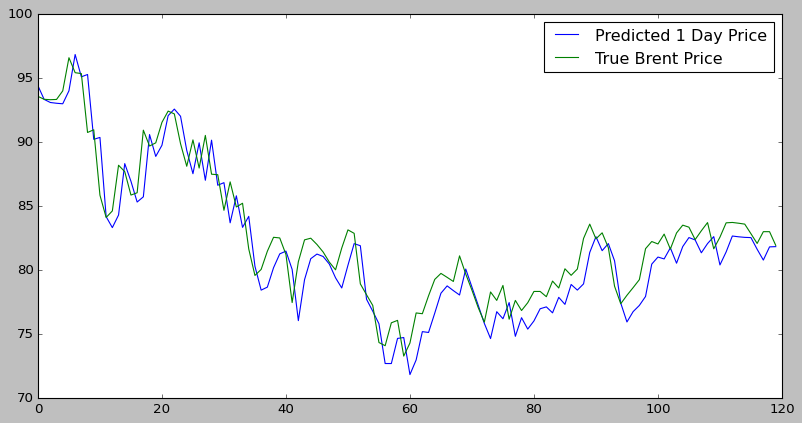

In [14]:
BrentModelPlot(1,450)

16/16 [==============================] - 1s 2ms/step


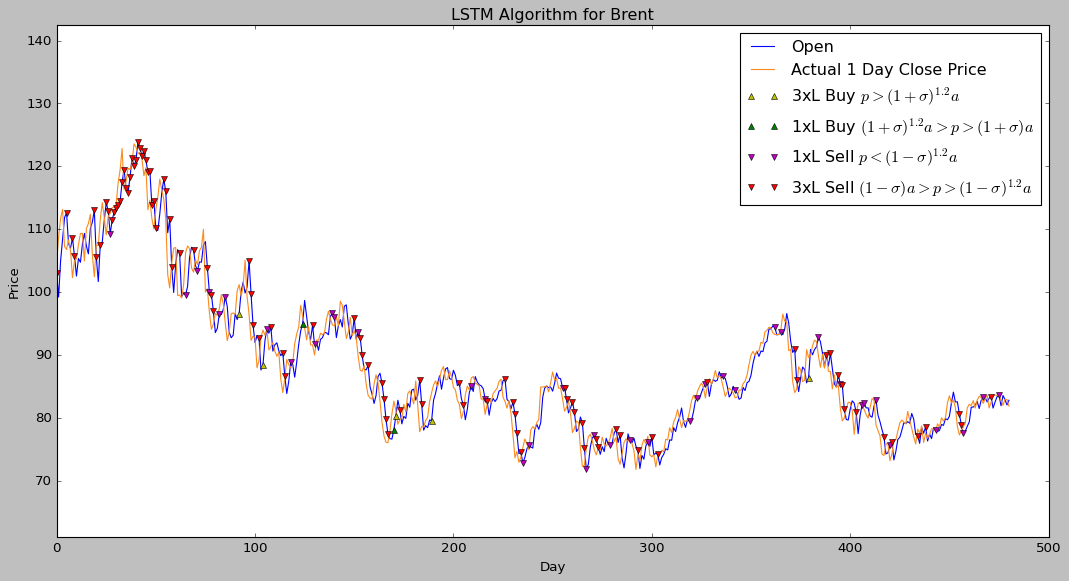

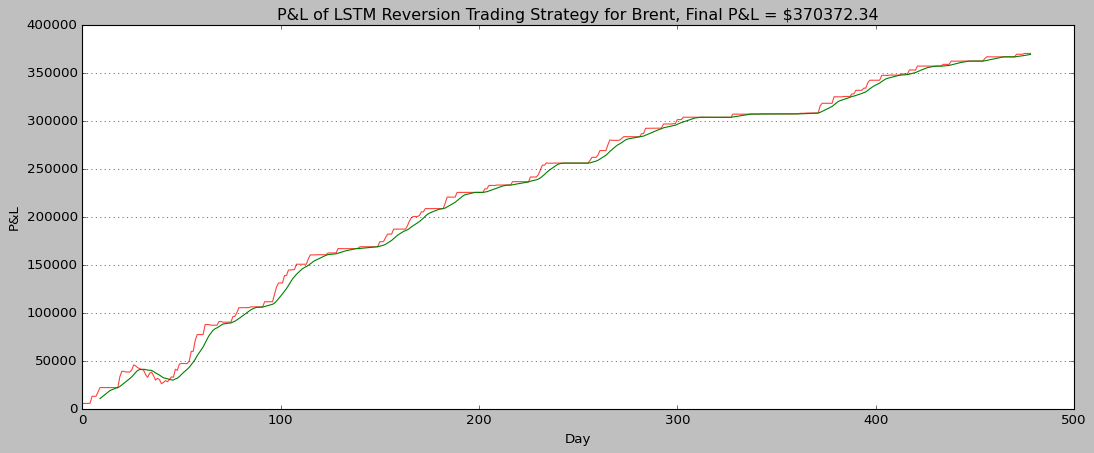

In [16]:
BrentModelSignal(1,450)

16/16 [==============================] - 1s 2ms/step


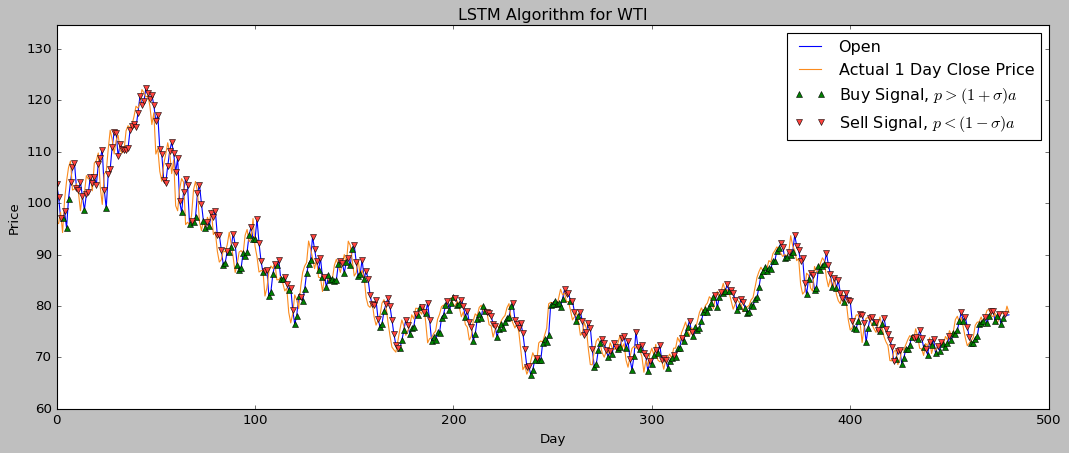

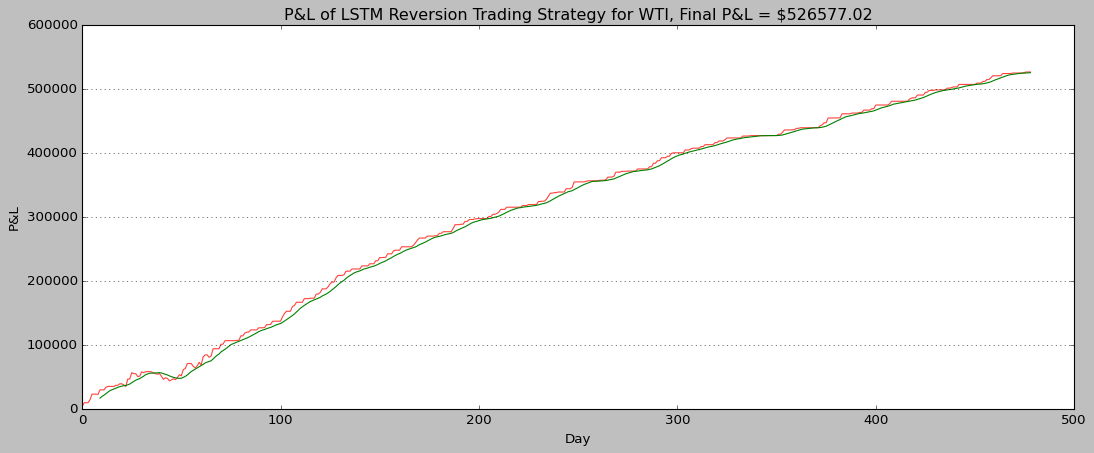

In [17]:
WTIModelSignal(1,350)

16/16 [==============================] - 1s 2ms/step


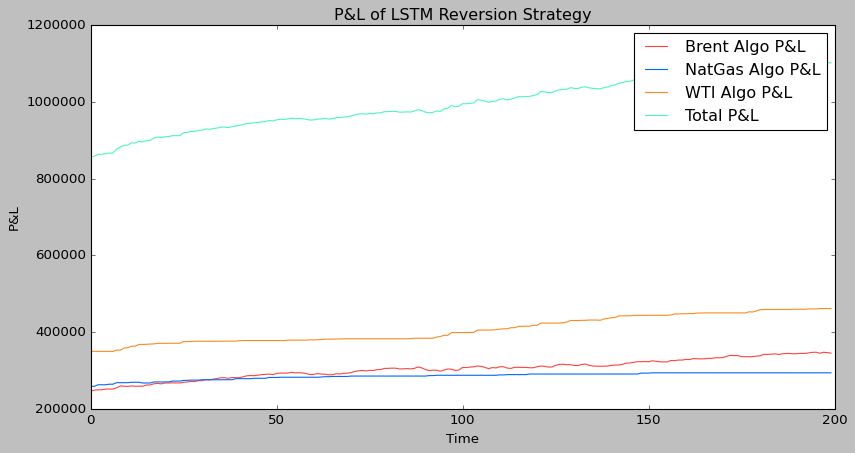

In [18]:
s = 1
e = 450

brent = BrentModel_PNL(s,e)[-200:]
wti = WTIModel_PNL(s,e)[-200:]
gas = GasModel_PNL(s,e)[-200:]
plt.figure(figsize = (12,6))
plt.plot(brent, color = blmbg_red, label = 'Brent Algo P&L')
plt.plot(gas, color = blmbg_blue, label = 'NatGas Algo P&L')
plt.plot(wti, color = blmbg_or, label = 'WTI Algo P&L')
plt.plot(wti + brent + gas, color = blmbg_cyan, label = 'Total P&L')
plt.legend()
plt.xlabel('Time')
plt.ylabel('P&L')
plt.title('P&L of LSTM Reversion Strategy')
plt.show()